# Boreal Change (height, biomass) using Fire Polygon Database

Paul Montesano, PhD  
April 2024  

 - Read in a parquet that is a compilation of all boreal fires from:
    https://github.com/earthlab/firedpy

    `EarthLab Firedpy`  

    ```reference 
    Balch, J., St. Denis, L., Mahood, A. L., MietKiewicz, N., Williams, T., McGlinchy, J., & Cook, M. (2020). FIRED (Fire Events Delineation): An open, flexible algorithm &amp; database of US fire events derived from the MODIS burned area product (2001-19). Remote Sensing, 12, 3498. https://doi.org/10.3390/rs12213498
    ```
 - #### Explore change with ICESat-2/ATL08: 
     - Play with fire sizes and corresponding ICESat-2/ATL08  
     - Plot distributions of ICESat-2/ATL08 vegetation height pre- and post-fire  
     - break up by landcover class (LC)  
 - #### TODO: Explore change with gridded biomass, height  
      - read in tile index csv files (aka `tindex` files) that store the `s3` paths to all our biomass and height raster output on MAAP  
      - begin exploring change in pre- and post-fire raster values associated with fire polygons 
      - explore a variety of ways to identify/quantify change (eg, raster differencing is the most simple)
      - start small; scale up

In [ ]:
!pip install contextily

In [1]:
import geopandas as gpd
import pandas as pd
import sys, os
sys.path.append('/projects/code/icesat2_boreal/lib')
import maplib_folium
from plotnine import *
import contextily as ctx

In [2]:
# Boreal Tiles 
boreal_tiles_model_ready_fn = '/projects/shared-buckets/montesano/databank/boreal_tiles_v004_model_ready.gpkg'
boreal_tiles = gpd.read_file(boreal_tiles_model_ready_fn)

# Explore change with ICESat-2/ATL08 observations

### Initial geodataframe cleaning
one off

In [3]:
if False:
    fires_gdf = gpd.read_file('/projects/shared-buckets/tonyumd/fire_geodataframe/fire_geodataframe.shp')
    fires_gdf['fid'] = fires_gdf['fid'].astype(int)
    fires_gdf['id'] = fires_gdf['id'].astype(int)
    fires_gdf.drop('path', axis=1, inplace=True)
    fires_gdf.reset_index(inplace=True)
    # The save was fast - geopackage was slow
    fires_gdf.to_parquet('/projects/my-public-bucket/databank/fire_perimeters/firedpy_boreal.parquet')

### Explore fire data

In [4]:
fires_gdf = gpd.read_parquet('/projects/my-public-bucket/databank/fire_perimeters/firedpy_boreal.parquet')
fires_gdf['year'] = fires_gdf['ig_year'].astype(str)

In [5]:
fires_gdf.groupby('layer').agg(cnt_fires=('layer', 'count'), max_km2=('tot_ar_km2', 'max'), med_km2=('tot_ar_km2', 'median'))

,cnt_fires,max_km2,med_km2
layer,,,
Alaska,23205,3398.046798,0.643976
Canada,88138,4732.579770,0.214659
China,136109,7239.578416,0.214659
Mongolia,9542,7239.578416,0.429317
North Europe,1009,117.847612,0.429317
Russia,965463,10434.987426,0.429317
UK&Ireland,779,58.816476,0.429317
West Europe,1088,90.156643,0.643976


In [6]:
fires_gdf[fires_gdf.tot_ar_km2 > 5e2].shape

(578, 36)

<Axes: >

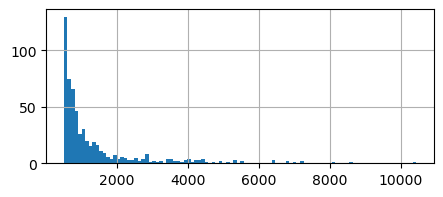

In [7]:
fires_gdf[fires_gdf.tot_ar_km2 > 5e2].tot_ar_km2.hist(bins=100, figsize=(5,2))

#### Map fire polygons and our boreal tiles

In [ ]:
fires_gdf[fires_gdf.tot_ar_km2 > 5e2].explore(m = boreal_tiles.explore(), column='year', cmap='inferno', legend=True, tiles=maplib_folium.tiler_basemap_gray, attr=' ')

In [9]:
import matplotlib.pyplot as plt

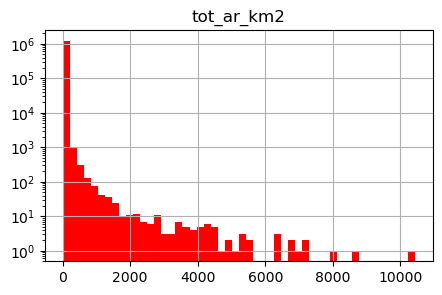

In [10]:
fires_gdf.hist(column='tot_ar_km2', bins=50, figsize=(5,3), color='red')
plt.yscale('log')

## ICESat-2/ATL08 in fire polygons
Show large fires post-ATL08?

#### Find the `tindex` csv files of our yearly ATL08 30m observations used for each year of this project (2019-2023)

In [ ]:
import mosaiclib
from mosaiclib import *

In [5]:
for k, v in ATL08_FILT_TINDEX_FN_DICT.items():
    print(v.replace('extract_atl08_covars', 'process_atl08_boreal/030m'))

s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/ATL08_filt/c2020/tile_atl08/ATL08_filt_tindex_master.csv
s3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/fall2022/with_gedi_rh/ATL08_filt_tindex_master.csv
s3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/fall2022/with_atl03_rh/ATL08_filt_tindex_master.csv
s3://maap-ops-workspace/shared/montesano/DPS_tile_lists/ATL08/tile_atl08/c2020_v005/ATL08_filt_tindex_master.csv
s3://maap-ops-workspace/shared/montesano/DPS_tile_lists/ATL08/process_atl08_boreal/030m/2019/ATL08_filt_tindex_master.csv
s3://maap-ops-workspace/shared/montesano/DPS_tile_lists/ATL08/process_atl08_boreal/030m/2020/ATL08_filt_tindex_master.csv
s3://maap-ops-workspace/shared/montesano/DPS_tile_lists/ATL08/process_atl08_boreal/030m/2021/ATL08_filt_tindex_master.csv
s3://maap-ops-workspace/shared/montesano/DPS_tile_lists/ATL08/process_atl08_boreal/030m/2022/ATL08_filt_tindex_master.csv
s3://maap-ops-workspace/shared/montesano/DPS_tile_lists/ATL08/pro

In [20]:
YEAR_ATL08 = 2021

In [21]:
ATL08_filt_tindex = pd.read_csv(f'/projects/my-public-bucket/DPS_tile_lists/ATL08/process_atl08_boreal/030m/{YEAR_ATL08}/ATL08_filt_tindex_master.csv')

In [22]:
boreal_tiles_ATL08_filt = boreal_tiles.merge(ATL08_filt_tindex[['tile_num', 'n_obs']], on='tile_num', suffixes = ['.atl08v005','.atl08v006'])

### Play with year & fire size thresholds

In [23]:
YEAR_FIRE = 2021
MIN_FIRE_SZ = 2e2
MAX_FIRE_SZ = 1e2

YEAR_ATL08_PREFIRE = YEAR_FIRE-1
YEAR_ATL08_POSTFIRE = YEAR_FIRE+1
YEAR_ATL08_POSTFIRE2 = YEAR_FIRE+2

fires_sub_large = fires_gdf[(fires_gdf.tot_ar_km2 > MIN_FIRE_SZ)&(fires_gdf.ig_year >=YEAR_FIRE)]
fires_sub_small = fires_gdf[(fires_gdf.tot_ar_km2 < MAX_FIRE_SZ)&(fires_gdf.ig_year >=YEAR_FIRE)]

In [24]:
print(f"{YEAR_FIRE}: {fires_sub_large.shape[0]} fires > {MIN_FIRE_SZ} km2")
print(f"{YEAR_FIRE}: {fires_sub_small.shape[0]} fires < {MAX_FIRE_SZ} km2")

2021: 102 fires > 200.0 km2
2021: 29936 fires < 100.0 km2


In [25]:
# Get tiles intersecting fires post-ATL08
#boreal_tiles_ATL08_fires_large = boreal_tiles_ATL08_filt[boreal_tiles_ATL08_filt.intersects(fires_sub_large.to_crs(boreal_tiles_ATL08_filt.crs).geometry)]
#boreal_tiles_ATL08_fires_small = boreal_tiles_ATL08_filt[boreal_tiles_ATL08_filt.intersects(fires_sub_small.to_crs(boreal_tiles_ATL08_filt.crs).geometry)]

### Get boreal tiles associated with fires

/opt/conda/envs/pangeo/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
/opt/conda/envs/pangeo/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.


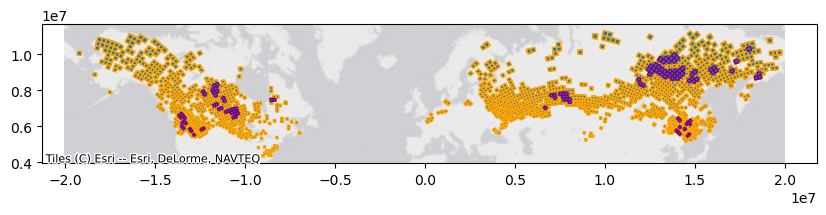

In [26]:
boreal_tiles_ATL08_fires_large = gpd.sjoin(boreal_tiles_ATL08_filt, fires_sub_large.to_crs(boreal_tiles_ATL08_filt.crs), op='intersects')
boreal_tiles_ATL08_fires_small = gpd.sjoin(boreal_tiles_ATL08_filt, fires_sub_small.to_crs(boreal_tiles_ATL08_filt.crs), op='intersects')

ax = boreal_tiles_ATL08_fires_small.to_crs(3857).plot(ec='orange', figsize=(10, 4))
ax = boreal_tiles_ATL08_fires_large.to_crs(3857).plot(ec='purple', ax=ax)

ctx.add_basemap(ax, source = ctx.providers.Esri.WorldGrayCanvas, )

## Clip ICESat-2/ATL08 to all areas with subsequent fires

### ATL08 for small fires

In [27]:
# TODO: this is slow - needs to be multiprocessed

In [ ]:
%%time
atl08_pre_fires = pd.concat([gpd.clip(gpd.read_parquet(f'/projects/my-private-bucket/data/process_atl08_boreal/030m/{YEAR_ATL08_PREFIRE}/atl08_006_030m_{YEAR_ATL08_PREFIRE}_{YEAR_ATL08_PREFIRE}_06_09_filt_{FOCAL_TILE:05}.parquet'), fires_sub_small.to_crs(7912)) for FOCAL_TILE in boreal_tiles_ATL08_fires_small.tile_num.to_list()])
atl08_pre_fires['status'] = f'pre-fire ({YEAR_ATL08_PREFIRE})'
atl08_post_fires = pd.concat([gpd.clip(gpd.read_parquet(f'/projects/my-private-bucket/data/process_atl08_boreal/030m/{YEAR_ATL08_POSTFIRE}/atl08_006_030m_{YEAR_ATL08_POSTFIRE}_{YEAR_ATL08_POSTFIRE}_06_09_filt_{FOCAL_TILE:06}.parquet'), fires_sub_small.to_crs(7912)) for FOCAL_TILE in boreal_tiles_ATL08_fires_small.tile_num.to_list()])
atl08_post_fires['status'] = f'post-fire ({YEAR_ATL08_POSTFIRE})'
atl08_post_fires2 = pd.concat([gpd.clip(gpd.read_parquet(f'/projects/my-private-bucket/data/process_atl08_boreal/030m/{YEAR_ATL08_POSTFIRE2}/atl08_006_030m_{YEAR_ATL08_POSTFIRE2}_{YEAR_ATL08_POSTFIRE2}_06_09_filt_{FOCAL_TILE:06}.parquet'), fires_sub_small.to_crs(7912)) for FOCAL_TILE in boreal_tiles_ATL08_fires_small.tile_num.to_list()])
atl08_post_fires2['status'] = f'post-fire2 ({YEAR_ATL08_POSTFIRE2})'

In [ ]:
print(f"{YEAR_FIRE}: {fires_sub_small.shape[0]} fires > {FIRE_SZ} km2")
print(f"{atl08_pre.shape[0]:,} pre-fire ATL08 30m obs.")
print(f"{atl08_post.shape[0]:,} post-fire ATL08 30m obs.")
print(f"{atl08_post2.shape[0]:,} post-fire (2nd yr) ATL08 30m obs.")

In [ ]:
# atl08_pre_fires = gpd.clip(atl08_pre, fires_sub.to_crs(atl08_pre.crs))
# atl08_pre_fires['status'] = f'pre-fire ({YEAR_ATL08_PREFIRE})'
# atl08_post_fires = gpd.clip(atl08_post, fires_sub.to_crs(atl08_post.crs))
# atl08_post_fires['status'] = f'post-fire ({YEAR_ATL08_POSTFIRE})'
# atl08_post_fires2 = gpd.clip(atl08_post2, fires_sub.to_crs(atl08_post.crs))
# atl08_post_fires2['status'] = f'post-fire2 ({YEAR_ATL08_POSTFIRE2})'

In [ ]:
atl08 = pd.concat([atl08_pre_fires, atl08_post_fires, atl08_post_fires2])

In [ ]:
atl08_fire = gpd.sjoin(atl08, fires_sub_small.to_crs(atl08.crs)[['geometry','fid']], op='intersects')

### Plot ATL08 heights in fire polys PRE- and POST- fire year

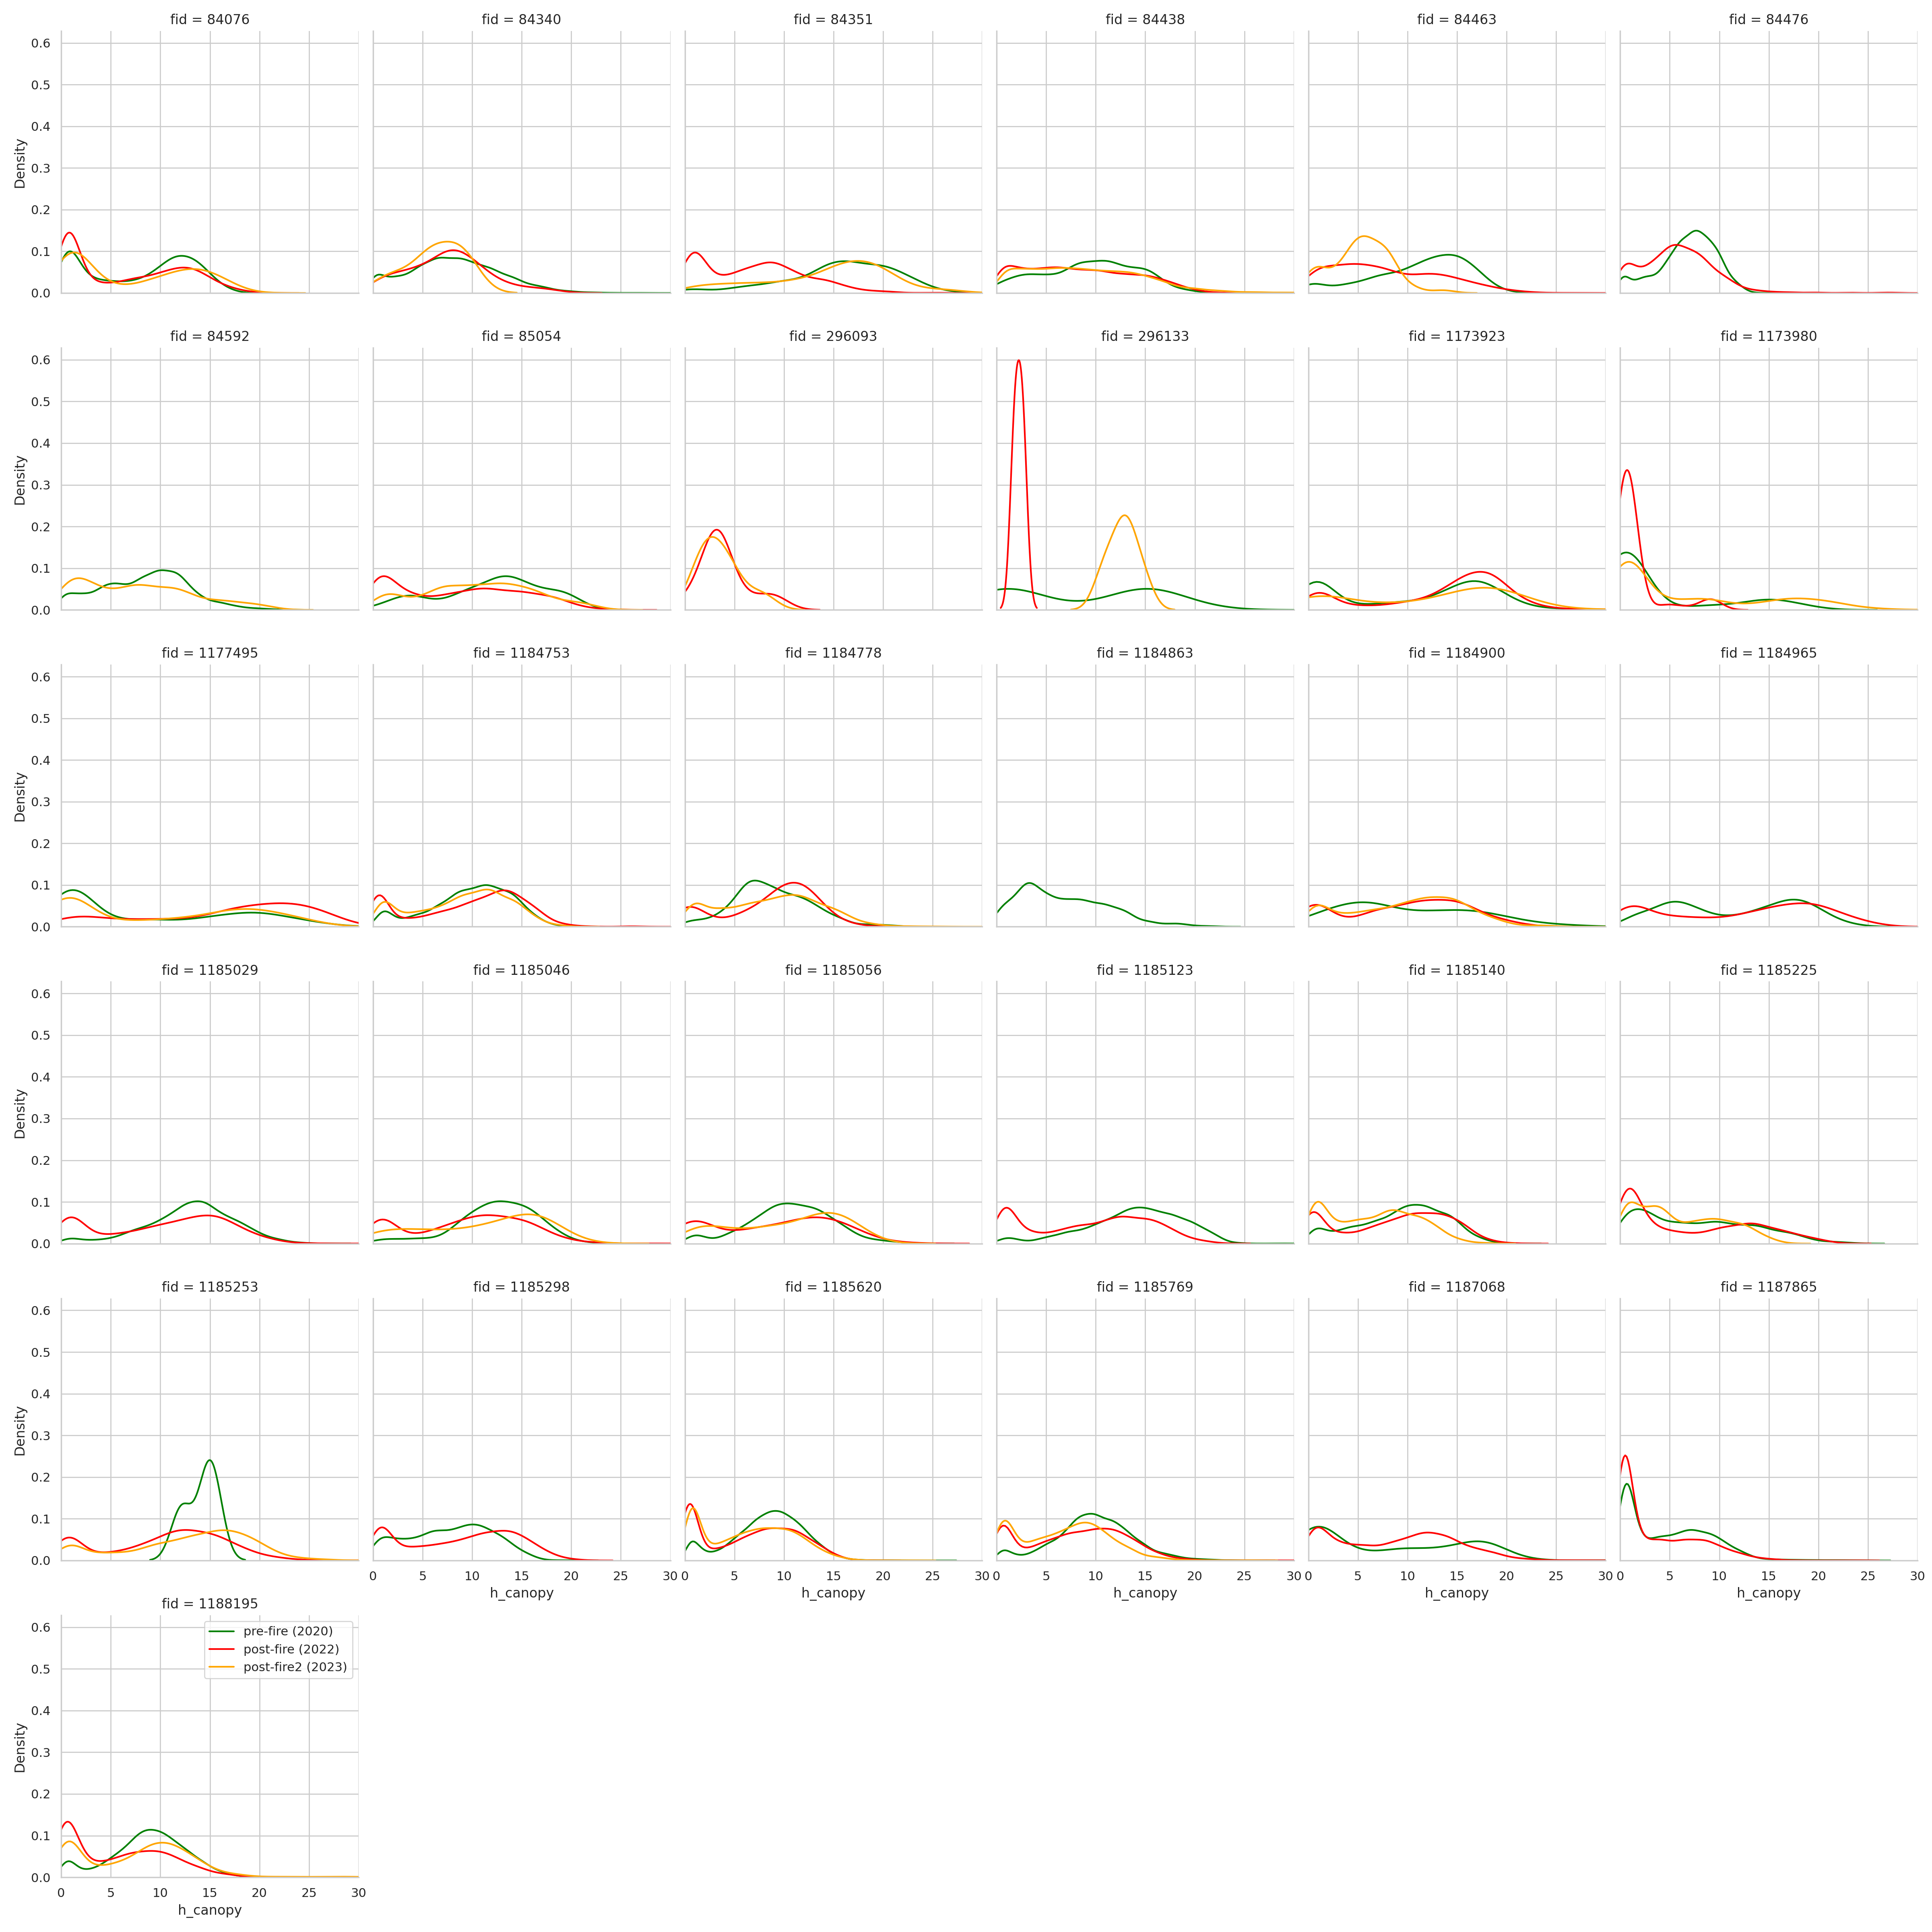

In [325]:
palette = ["green", "red", "orange"]

# Set up the figure and axes for subplots
g = sns.FacetGrid(atl08_fire, col="fid", hue='status', height=4, aspect=1, col_wrap=6, palette=sns.color_palette(palette, 3))

# Plot stacked histogram for each facet
#g.map(sns.histplot, "h_canopy", bins=20,  multiple="stack", legend=True, kde=True)
g.map(sns.kdeplot, "h_canopy", common_norm=True)
plt.xlim(0, 30)
plt.legend(loc='upper right')
plt.show()

In [289]:
atl08_fire.columns

Index(['ph_count', 'h_te_median', 'h_max_canopy', 'canopy_openness', 'gt',
       'snowcover', 'cycle', 'h_canopy', 'rgt', 'gnd_ph_count', 'spot',
       'h_mean_canopy', 'solar_elevation', 'h_min_canopy', 'veg_ph_count',
       'x_atc', 'extent_id', 'landcover', 'segment_id', 'geometry', 'num_bins',
       'binsize', 'h_dif_ref', 'msw_flag', 'sigma_topo', 'segment_landcover',
       'segment_snowcover', 'rh25', 'rh50', 'rh60', 'rh70', 'rh75', 'rh80',
       'rh85', 'rh90', 'rh95', 'h_canopy_uncertainty', 'segment_cover',
       'h_te_uncertainty', 'y', 'm', 'd', 'doy', 'beam_type', 'status',
       'index_right', 'fid'],
      dtype='object')

In [ ]:
atl08_fire_smry = atl08_fire.groupby(['fid','status','landcover']).agg(h_can_median=('h_canopy', 'median'), h_can_std=('h_canopy', 'std'),  h_can_cnt=('h_canopy', 'count')).reset_index()
atl08_fire_smry[atl08_fire_smry.fid == 84076].head()

### Distributions of ICESat-2/ATL08 vegetation heights pre and post fire, by LC class
https://icesat-2.gsfc.nasa.gov/sites/default/files/page_files/ICESat2_ATL08_ATBD_r006.pdf  
land cover classes

In [ ]:
(
 ggplot(atl08_fire, mapping=aes(x='factor(landcover)'))
    #+ geom_boxplot(mapping=aes(y='rh50', fill='status'), position = position_dodge(width=1), outlier_alpha=0, alpha=0.5)
    + geom_boxplot(mapping=aes(y='h_canopy', fill='status'), position = position_dodge(width=1), outlier_alpha=0, alpha=0.5)
    + facet_wrap('~landcover', ncol=8, scales='free')
    + scale_fill_manual(values=['#fc8d62','#a6d854'])
    + theme_bw()
    + theme(figure_size=(15,6),
             axis_text_x = element_blank())
    #+ coord_cartesian(ylim=[0,20])
    + labs(x='', y='Canopy height [m, median]\nwithin fire extent')
)

Text(0, 0.5, '# ATL08 30m obs.')

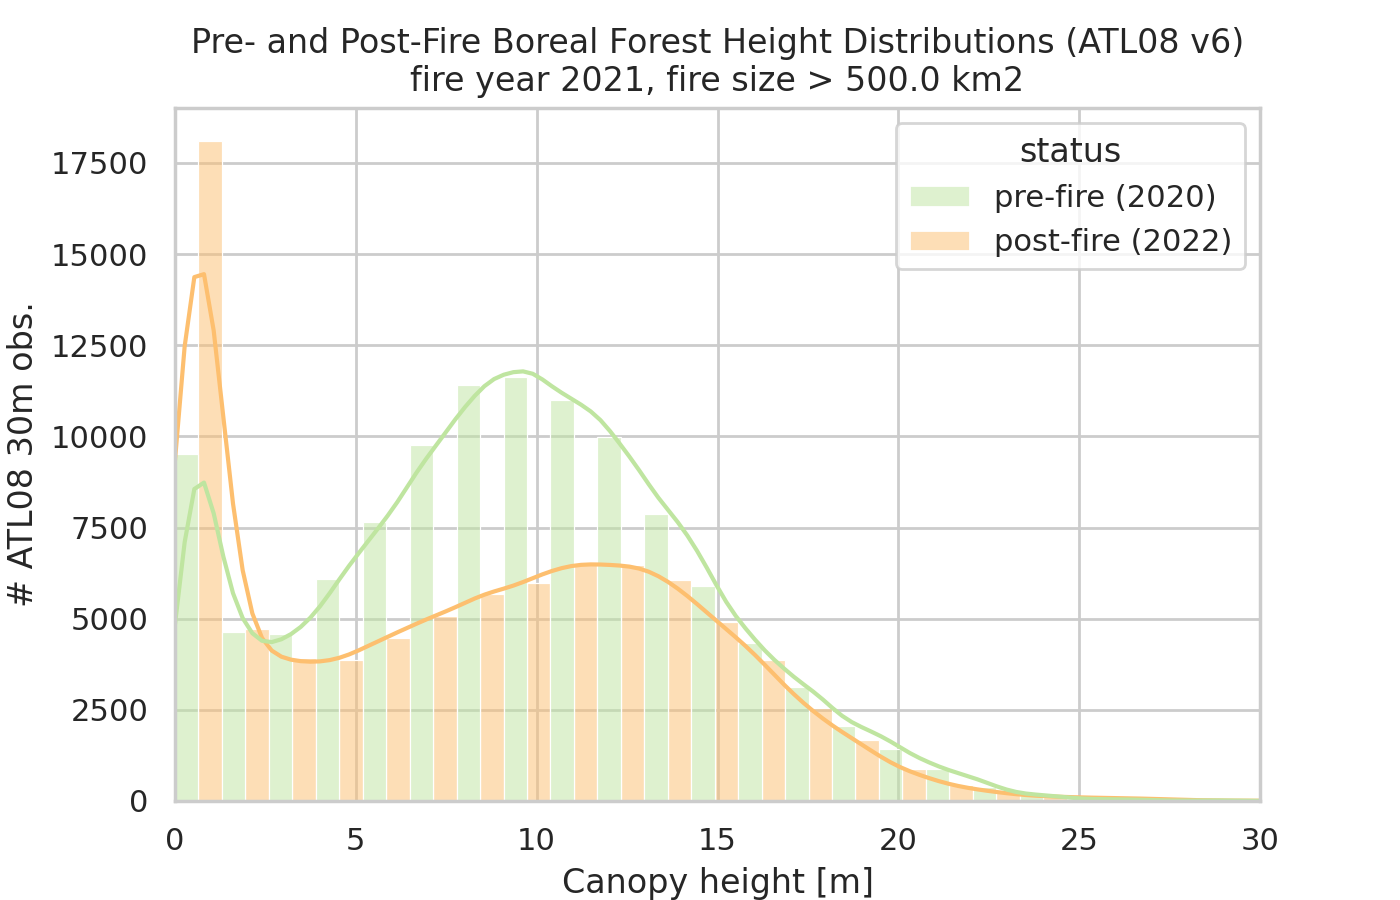

In [195]:
# stacked histogram
import matplotlib.pyplot as plt
f = plt.figure(figsize=(7,4.5))
ax = f.add_subplot(1,1,1)

# plot
import seaborn as sns
ax = sns.histplot(data=atl08, ax=ax, stat="count", multiple="dodge", #stack
             x="h_canopy", kde=True,
             palette="Spectral_r", hue="status", bins=41,
             #element="bars",
                  legend=True )


ax.set_xlim(0, 30)
ax.set_title(f"Pre- and Post-Fire Boreal Forest Height Distributions (ATL08 v6)\nfire year {YEAR_FIRE}, fire size > {FIRE_SZ} km2")
ax.set_xlabel("Canopy height [m]")
ax.set_ylabel("# ATL08 30m obs.")

In [71]:
import importlib
import maplib_folium
importlib.reload(maplib_folium)

<module 'maplib_folium' from '/projects/code/icesat2_boreal/lib/maplib_folium.py'>

In [ ]:
maplib_folium.map_tile_atl08(boreal_tiles_ATL08_fires.tile_num.to_list(), None, boreal_tiles, ATL08_filt_tindex_master_fn = atl08_subsequent_fires.sample(frac=0.1),
                             DO_NIGHT=False,
                  map_width = 600, map_height=1200, OVERVIEW_MAP= True,
                  max_AGB_display = 50, max_AGBSE_display = 20
                 )

# Explore change in gridded biomass, height derived from ICESat-2/ATL08 and covariates

#### Find the `tindex` csv files of our yearly biomass, height grids processed for each year of this project (2019-2023)

In [33]:
[print(var) for var in locals() if 'TINDEX_FN_DICT' in var]

ATL08_GRANULE_TINDEX_FN_DICT
ATL08_FILT_TINDEX_FN_DICT
AGB_TINDEX_FN_DICT
HLS_TINDEX_FN_DICT
SAR_TINDEX_FN_DICT
LC_TINDEX_FN_DICT
TOPO_TINDEX_FN_DICT
HT_TINDEX_FN_DICT


[None, None, None, None, None, None, None, None]

In [34]:
AGB_TINDEX_FN_DICT

{'2019_v1.9': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2019/2019_fullboreal_2019lidar/AGB_tindex_master.csv',
 '2020_v1.9': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2020/atl08_v6_fullboreal_min5000_90p_local/AGB_tindex_master.csv',
 '2021_v1.9': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2021/2021_fullboreal_2021lidar/AGB_tindex_master.csv',
 '2022_v1.9': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2022/2022_fullboreal_2022lidar/AGB_tindex_master.csv',
 '2023_v1.9': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2023/2023_full_2023lidar/AGB_tindex_master.csv',
 '2020_v2.0': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v6/AGB_H30_2020/Version2_SD/AGB_tindex_master.csv'}

In [35]:
HT_TINDEX_FN_DICT

{'2020_v2.0': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v6/Ht_H30_2020/Version2_SD/HT_tindex_master.csv'}